In [46]:
import sys
import time
import pickle
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, scale

In [47]:
#----- Load data
with open('data/non_gene_seqs.pkl', 'rb') as f1:
    non_gene = pickle.load(f1)
with open('data/gene_seqs.pkl', 'rb') as f2:
    gene = pickle.load(f2)

# Check class balance
print("# non gene examples: {}".format(len(non_gene)))
print("# gene examples: {}".format(len(gene)))
    
# Check for weird bases (i.e. check only A, C, T, G)
print("Bases in non gene: {}".format(set("".join(non_gene))))
print("Bases in gene: {}".format(set("".join(gene))))

# non gene examples: 19800
# gene examples: 19425
Bases in non gene: {'T', 'A', 'G', 'C'}
Bases in gene: {'T', 'A', 'G', 'C'}


In [64]:
#------- Form test, train and validation sets (class 0 is non-gene and class 1 is gene)
df_non_gene = pd.DataFrame.from_dict({'sequence':non_gene, 'class': 0})
df_gene = pd.DataFrame.from_dict({'sequence':gene, 'class': 1})
df = pd.concat([df_non_gene, df_gene])
df = df.sample(frac=1)  # randomly shuffle dataframe rows
# df['tata'] = list(map(int, df['sequence'].str.contains('TATAAA')))
# df['atg_count'] = list(map(int, df['sequence'].str.contains('ATG')))

train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(df, test_size=0.1)
print("Train:{}, test:{}, validation:{}".format(len(train), len(test), len(val)))

# Frequency of bases in positive and negative examples
gene_string = "".join(df_gene['sequence'].tolist())
non_gene_string = "".join(df_non_gene['sequence'].tolist())
print(collections.Counter(gene_string))
print(collections.Counter(non_gene_string))

# Checking for TATA box
print("TATA present {} times in gene examples".format(gene_string.count("TATAAA")))
print("Start codon present {} times gene examples".format(gene_string.count("ATG")))
print("TATA present {} times non-gene examples".format(non_gene_string.count("TATAAA")))
print("Start codon present {} times non-gene examples".format(non_gene_string.count("ATG")))
# sum(['TATAAA' in g for g in gene])
# sum(['TATAAA' in g for g in non_gene])

Train:35302, test:7845, validation:3923
Counter({'G': 5697966, 'C': 5539227, 'T': 4114385, 'A': 4073422})
Counter({'A': 5772178, 'T': 5766107, 'C': 4135339, 'G': 4126376})
TATA present 4556 times in gene examples
Start codon present 204151 times gene examples
TATA present 13371 times non-gene examples
Start codon present 357576 times non-gene examples


In [65]:
#------ Convert to test and train matrices
word_dict = dict(zip(['A', 'C', 'G', 'T'], list(range(4))))
print(word_dict)

def gene_seq_to_vec(seq, word_dict):
    for key in word_dict:
        seq = seq.replace(key, str(word_dict[key]))
    return [int(s) for s in list(seq)]

def gene_seq_to_mat(seq, word_dict):
    for key in word_dict:
        seq = seq.replace(key, str(word_dict[key]))
    x = np.array([int(s) for s in list(seq)]).reshape(-1)
    x_mat = np.zeros([1000, 4])
    x_mat[np.arange(x.shape[0]), x.T-1] = 1
    return x_mat

X_train = np.stack([gene_seq_to_mat(seq, word_dict) for seq in train['sequence'].tolist()])
X_test = np.stack([gene_seq_to_mat(seq, word_dict) for seq in test['sequence'].tolist()])
X_val = np.stack([gene_seq_to_mat(seq, word_dict) for seq in val['sequence'].tolist()])
# X_train = np.array([gene_seq_to_vec(x, word_dict) for x in train['sequence'].tolist()])
# X_test = np.array([gene_seq_to_vec(x, word_dict) for x in test['sequence'].tolist()])
# X_val = np.array([gene_seq_to_vec(x, word_dict) for x in val['sequence'].tolist()])
# train_tata = np.array(train['tata'].tolist()).reshape(-1, 1)
# val_tata = np.array(val['tata'].tolist()).reshape(-1, 1)
# test_tata = np.array(test['tata'].tolist()).reshape(-1, 1)

y_train = np.array(train['class'].tolist()).reshape(-1, 1)
y_test = np.array(test['class'].tolist()).reshape(-1, 1)
y_val = np.array(val['class'].tolist()).reshape(-1, 1)

{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [85]:
#------- Initialize TF graph and set training paramaters - CNN-based approach
tf.reset_default_graph()
learning_rate = 0.001
b_size = 50
filter_sizes = [24]
num_filters = 64
n_epochs = 15

x = tf.placeholder(tf.int32, [None, 1000, 4])
# x_tata = tf.placeholder(tf.float32, [None, 1])
y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)

def cnn_text(x, y, num_filters, filter_sizes, learning_rate):
    """Build TF computation graph for CNN"""
    x = tf.expand_dims(x, -1)
    num_filters_total = num_filters * len(filter_sizes)
    
    W_h = tf.get_variable("W_h", [32, 64], 
        initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
    b_h = tf.get_variable("b_h", [64],initializer=tf.constant_initializer(0.01))    
    W_out = tf.get_variable("W_out", [64, 1], 
        initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01))
    b_out = tf.get_variable("b_out", [1],initializer=tf.constant_initializer(0.01))
    
    # Convolutional layers - to produce feature vector
    pooled_outputs = []
    for i, filter_size in enumerate(filter_sizes):
        with tf.name_scope("conv-maxpool-%s" % filter_size):
            filter_shape = [filter_size, 4, 1, num_filters]
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.01, shape=[num_filters]), name="b")
            conv = tf.nn.conv2d(tf.cast(x, tf.float32), W, 
                                     strides=[1, 1, 1, 1], padding="VALID", name="conv")
            h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
            pooled = tf.nn.max_pool(h, ksize=[1, 1000-filter_size+1, 1, 1],
                strides=[1, 1, 1, 1], padding='VALID', name="pool")
            pooled_outputs.append(pooled)
            
    # Fully connected layers
    h_pool = tf.concat(pooled_outputs, 3)
    h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])
#     h_pool_flat = tf.concat([h_pool_flat, x_tata], axis=1)  # include tata box feature
    h_drop = tf.nn.dropout(h_pool_flat, keep_prob)
    h_drop = tf.expand_dims(h_drop, -1)
#     output = tf.matmul(h_drop, W_out) + b_out
#     y_pred = tf.nn.sigmoid(output)

    # LSTM layer
    lstm = tf.contrib.rnn.BasicLSTMCell(num_units=32)
    outputs, state = tf.nn.dynamic_rnn(cell=lstm, dtype=tf.float32, inputs=h_drop)

    # Linear layer + ReLU + linear layer
    final_output = outputs[:, -1, :]
    final_output = tf.nn.dropout(final_output, keep_prob)
    h_rnn = tf.nn.relu(tf.matmul(final_output, W_h) + b_h)
    out = tf.matmul(h_rnn, W_out) + b_out
    y_pred = tf.nn.sigmoid(out)
    
    # Loss and optimizer
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=out))
    acc = tf.reduce_sum(tf.cast(tf.equal(tf.round(y_pred), y), 'float'))
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return y_pred, loss, opt, acc, h_drop

y_pred, loss, opt, acc, h_drop = cnn_text(x, y, num_filters, filter_sizes, learning_rate)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [86]:
#-------- Split into batches and train
X_train_batch_list = np.array_split(X_train, int(len(train)/b_size))
# tata_train_list = np.array_split(train_tata, int(len(train)/b_size))
y_train_batch_list = np.array_split(y_train, int(len(train)/b_size))

# To print progress and store results throughout training
def progress_bar(value, endvalue, bar_length=20):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\rPercent complete: [{0}] {1}%".format(arrow + spaces, int(round(percent*100))))
    sys.stdout.flush()
    
train_results_dict = {
    'n_examples': [], 
    'batch_train_loss': [], 'validation_loss': [],
    'batch_train_acc': [], 'validation_acc': []
}
save_results_freq = 50

# Run TF session
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        print("#------- Running for epoch {} of {}".format(epoch+1, n_epochs))
        for i in range(len(X_train_batch_list)):
            train_dict = {
                x: X_train_batch_list[i], y: y_train_batch_list[i], keep_prob: 0.65
            }
            y_p, l, o, a = sess.run([y_pred, loss, opt, acc], feed_dict=train_dict)
            progress_bar(i+1, len(X_train_batch_list))
            if i % save_results_freq == 0:
                l_val, acc_val = sess.run([loss, acc], feed_dict={x: X_val, y: y_val, keep_prob:1})
                train_results_dict['n_examples'].append(i * b_size + epoch * len(y_train))
                train_results_dict['batch_train_loss'].append(l)
                train_results_dict['validation_loss'].append(l_val)
                train_results_dict['batch_train_acc'].append(a/b_size)
                train_results_dict['validation_acc'].append(acc_val/len(y_val))
                
        l_train, acc_train = sess.run([loss, acc], feed_dict={x: X_train, y: y_train, keep_prob:1})
        saver.save(sess, 'models/cnn_text_model')
        print("\nTrained for {} epochs: train loss = {}, train acc = {}".format(epoch+1, l_train, acc_train/len(y_train)))
        print("Val loss = {}, val acc = {}".format(l_val, acc_val/len(y_val)))
        
    sess.close()

#------- Running for epoch 1 of 15
Percent complete: [------------------->] 100%
Trained for 1 epochs: train loss = 0.36729180812835693, train acc = 0.8455328310010765
Val loss = 0.3781794309616089, val acc = 0.8376242671424929
#------- Running for epoch 2 of 15
Percent complete: [------------------->] 100%
Trained for 2 epochs: train loss = 0.34714651107788086, train acc = 0.856098804600306
Val loss = 0.3566703498363495, val acc = 0.8521539638032118
#------- Running for epoch 3 of 15
Percent complete: [------------------->] 100%
Trained for 3 epochs: train loss = 0.33813318610191345, train acc = 0.8604894906804147
Val loss = 0.352571040391922, val acc = 0.8572521029824114
#------- Running for epoch 4 of 15
Percent complete: [------------------->] 100%
Trained for 4 epochs: train loss = 0.32714954018592834, train acc = 0.8654750439068608
Val loss = 0.34581825137138367, val acc = 0.8539383125159317
#------- Running for epoch 5 of 15
Percent complete: [------------------->] 100%
Trained 

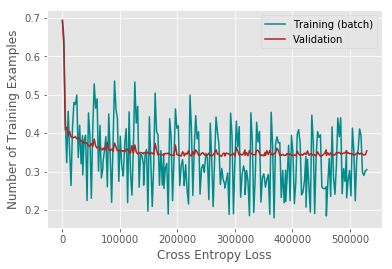

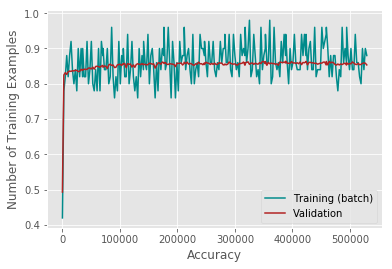

In [87]:
#------ Plot learning curves
with plt.style.context('ggplot'):
    # Loss plot
    plt.plot(train_results_dict['n_examples'], train_results_dict['batch_train_loss'], 
             'darkcyan', label="Training (batch)")
    plt.plot(train_results_dict['n_examples'], train_results_dict['validation_loss'],
            'firebrick', label="Validation")
    plt.ylabel('Number of Training Examples'); plt.xlabel('Cross Entropy Loss')
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.plot(train_results_dict['n_examples'], train_results_dict['batch_train_acc'], 
             'darkcyan', label="Training (batch)")
    plt.plot(train_results_dict['n_examples'], train_results_dict['validation_acc'], 
             'firebrick', label="Validation")
    plt.ylabel('Number of Training Examples'); plt.xlabel('Accuracy')
    plt.legend()
    plt.show()

In [88]:
#------ Reload model and get performance on the test set
print("#------ Reloading model...")
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("models/cnn_text_model.meta")
    saver.restore(sess, tf.train.latest_checkpoint("models"))
    all_vars = tf.get_collection('vars')
    l_test, acc_test = sess.run([loss, acc], feed_dict={x: X_test, y: y_test, keep_prob:1})
    sess.close()

print("#------ Calculating performance on test set...")
print("Test loss = {}, test acc = {}".format(l_test, acc_test/len(y_test)))

#------ Reloading model...
INFO:tensorflow:Restoring parameters from models/cnn_text_model
#------ Calculating performance on test set...
Test loss = 0.29457876086235046, test acc = 0.8790312300828553
